tidyish code for doing yearly output of OmA_depth

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
import matplotlib.patches as patches

import netCDF4 as nc
from cmocean import cm
import numpy as np
from salishsea_tools import (
    viz_tools,
    tidetools,
    geo_tools
)
import pickle
from mpl_toolkits.basemap import Basemap
import arrow
import glob
import xarray as xr

%matplotlib inline

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
frihar_j, frihar_i = geo_tools.find_closest_model_point(
                   -123.011909,48.543391,X,Y,land_mask=bathy.mask)

In [5]:

Frihar_oms = pickle.load(open('./Frihar_oms.pkl', 'rb'))  

Frihar_oms2 = pickle.load(open('./Frihar_oms2.pkl', 'rb'))  

In [6]:
start = '2017-01-01'
end = '2017-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array = []
for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)
    
date_array = []
for i in range(0,len(arrow_array)):    
    q = arrow_array[i][0]
    ddmmmyy = q.format('YYYYMMDD')
    tdir = f'/data/tjarniko/results/hindcast.201905_dayavg_OmA-pH-pCO2/*{ddmmmyy}.nc'
    tdir2 = glob.glob(tdir)
    date_array.append(tdir2[0])

In [7]:
def plot_basemap(ax, w_map, lons=None, lats=None, offset=[None, None], zorder=[0, 1, 2]):
    """
    """
    
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.floor([w_map[0], w_map[1] + 1])
    if lats is None:
        lats = np.floor([w_map[2], w_map[3] + 1])
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    m.fillcontinents(color='Burlywood', zorder=zorder[0])
    m.drawmeridians(np.arange(*lons), labels=[0, 0, 1, 0], rotation = 15, fontsize = 8, color='dimgray', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(np.arange(*lats), labels=[1, 0, 0, 0], fontsize = 8, color='dimgray', xoffset=offset[0], zorder=zorder[2])
    
    return m

def plot_thalweg(ax, T_lon, T_lat):
    lines = np.loadtxt('/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt', delimiter=" ", unpack=False)
    lines = lines.astype(int)

    thalweg_lon = T_lon[lines[:,0],lines[:,1]]
    thalweg_lat = T_lat[lines[:,0],lines[:,1]]
    ax.plot(thalweg_lon, thalweg_lat, 'r')

/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: No contour levels were found within the data range.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


(40, 365)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


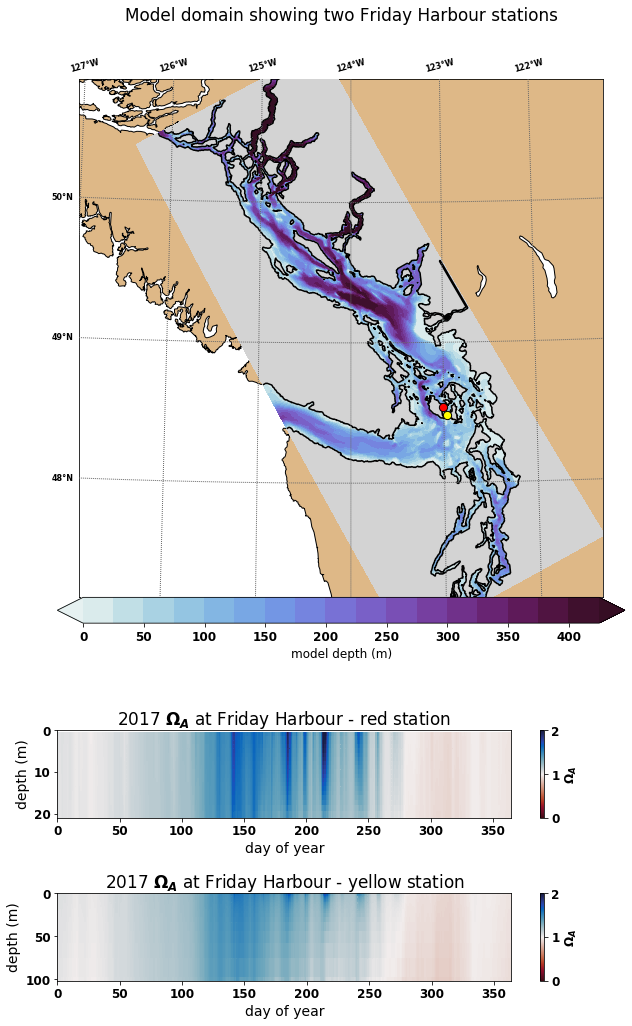

In [8]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

grid = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
bathy = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
meshmask = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

tmesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
fact = 1/72; fs = 12
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

fact = 0.9
fig = plt.figure(figsize=(10*fact, 16*fact))

ax1 = plt.subplot2grid((6,4), (0,0), colspan=4, rowspan=4) 
fa = 0.15
w_map = [-127+fa, -121-fa, 47+fa, 51.0-fa]
m = plot_basemap(ax1, w_map, zorder=[0, 1, 7]) #offset=[-30000, -15000]
x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)  
tdat_p = bathy['Bathymetry'][:]
mesh = ax1.contourf(x, y, tdat_p, levels=np.arange(0, 450, 25), \
                 cmap=cm.dense, extend = 'both') # extend='both', zorder=.2)

ax1.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
ax1.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)

ax1.scatter(x[frihar_j,frihar_i],y[frihar_j,frihar_i],\
            marker = 'o', edgecolor = 'k', s = 68, color = 'red', zorder = 10)
ax1.scatter(x[frihar_j-15,frihar_i+0],y[frihar_j-15,frihar_i+0],\
            marker = 'o', edgecolor = 'k', s = 68, color = 'yellow', zorder = 10)

cbar = fig.colorbar(mesh, ax=ax1, orientation = 'horizontal',fraction=0.1, pad=0.0)#, ticks = tticks)
cbar.set_label(label='model depth (m)', size=fs)
ax1.set_title('Model domain showing two Friday Harbour stations', y=1.1)

ax = plt.subplot2grid((6,4), (4,0), colspan=4, rowspan=1) 
tplt = Frihar_oms 
print(np.shape(tplt))
tcmap = cm.balance_r
cmap = tcmap
section_slice = np.arange(0,365)
zlevels = tmesh['gdept_1d'][:]
mesh = ax.pcolormesh(section_slice[:],zlevels[0],Frihar_oms, cmap = tcmap, vmin=0.0, vmax=2 )
ax.set_title('2017 $\Omega_A$ at Friday Harbour - red station')
ax.set_xlim([0,365])
ax.set_ylim([0,21])
ax.set_xlabel('day of year')
ax.set_ylabel('depth (m)')
ax.invert_yaxis()
cbar = plt.colorbar(mesh)
cbar.set_label(label='$\Omega_A$', size=fs)
    
ax = plt.subplot2grid((6,4), (5,0), colspan=4, rowspan=1) 
tplt = Frihar_oms2 
tcmap = cm.balance_r
cmap = tcmap
mesh = ax.pcolormesh(section_slice[:],zlevels[0],Frihar_oms2, cmap = tcmap,  vmin=0.0, vmax=2 )
ax.set_title('2017 $\Omega_A$ at Friday Harbour - yellow station')
ax.set_ylim([0,102])
ax.invert_yaxis()
cbar = plt.colorbar(mesh)
ax.set_xlabel('day of year')
ax.set_ylabel('depth (m)')
cbar.set_label(label='$\Omega_A$', size=fs)
plt.tight_layout()

In [9]:
# tmesh

/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: No contour levels were found within the data range.


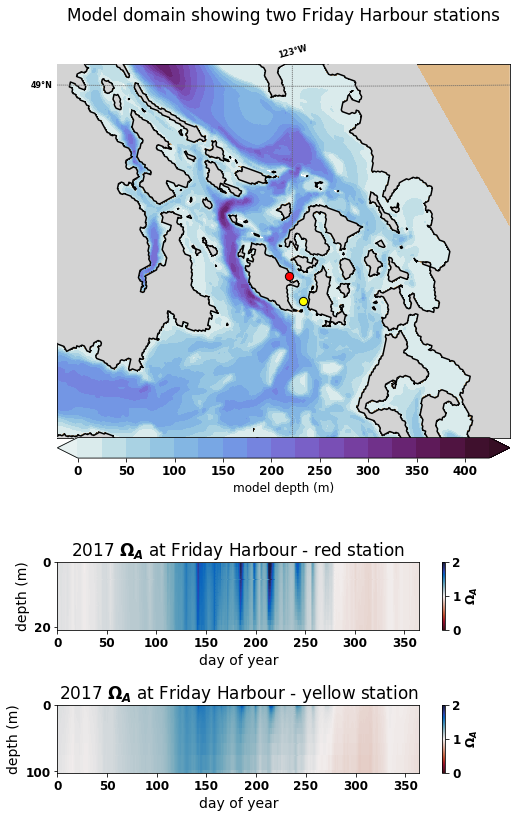

In [10]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

grid = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
bathy = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
meshmask = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

tmesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
fact = 1/72; fs = 12
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

fact = 0.75
fig = plt.figure(figsize=(10*fact, 16*fact))

ax1 = plt.subplot2grid((6,4), (0,0), colspan=4, rowspan=4) 
fa = 0.15
w_map = [-124+fa, -122.2, 48+fa, 49.2-fa]
m = plot_basemap(ax1, w_map, zorder=[0, 1, 7]) #offset=[-30000, -15000]
x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)  
tdat_p = bathy['Bathymetry'][:]
mesh = ax1.contourf(x, y, tdat_p, levels=np.arange(0, 450, 25), \
                 cmap=cm.dense, extend = 'both') # extend='both', zorder=.2)

ax1.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
ax1.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)

ax1.scatter(x[frihar_j,frihar_i],y[frihar_j,frihar_i],\
            marker = 'o', edgecolor = 'k', s = 68, color = 'red', zorder = 10)
ax1.scatter(x[frihar_j-15,frihar_i+0],y[frihar_j-15,frihar_i+0],\
            marker = 'o', edgecolor = 'k', s = 68, color = 'yellow', zorder = 10)
cbar = fig.colorbar(mesh, ax=ax1, orientation = 'horizontal',fraction=0.1, pad=0.0)#, ticks = tticks)
cbar.set_label(label='model depth (m)', size=fs)
ax1.set_title('Model domain showing two Friday Harbour stations', y=1.1)

ax = plt.subplot2grid((6,4), (4,0), colspan=4, rowspan=1) 
tplt = Frihar_oms 
tcmap = cm.balance_r
cmap = tcmap
mesh = ax.pcolormesh(section_slice[:],zlevels[0],Frihar_oms, cmap = tcmap, vmin=0.0, vmax=2 )
ax.set_title('2017 $\Omega_A$ at Friday Harbour - red station')
ax.set_xlim([0,365])
ax.set_ylim([0,21])
ax.set_xlabel('day of year')
ax.set_ylabel('depth (m)')
ax.invert_yaxis()
cbar = plt.colorbar(mesh)
cbar.set_label(label='$\Omega_A$', size=fs)
    
ax = plt.subplot2grid((6,4), (5,0), colspan=4, rowspan=1) 
tplt = Frihar_oms2 
tcmap = cm.balance_r
cmap = tcmap
mesh = ax.pcolormesh(section_slice[:],zlevels[0],Frihar_oms2, cmap = tcmap,  vmin=0.0, vmax=2 )
ax.set_title('2017 $\Omega_A$ at Friday Harbour - yellow station')
ax.set_ylim([0,102])
ax.invert_yaxis()
cbar = plt.colorbar(mesh)
ax.set_xlabel('day of year')
ax.set_ylabel('depth (m)')
cbar.set_label(label='$\Omega_A$', size=fs)
plt.tight_layout()

In [11]:
# #retreive yearly Omega
# Frihar_oms = np.zeros([40,365])
# for i in range(0,365):
#     if i == 0:
#         print(Frihar_oms2[:,i])
#     Frihar_omega = nc.Dataset(date_array[i])
#     Frihar_oms[:,i] = (Frihar_omega['model_output']['OmA'][:,frihar_j,frihar_i])
# pickle.dump(Frihar_oms, open("Frihar_oms.pkl", 'wb'))    
    

In [12]:
print('finished')

finished
